In [7]:
from utils import *
from MySolution import MyClassifier, MyClustering, MyLabelSelection

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Synthetic data shape:  (1000, 2) (1000,)


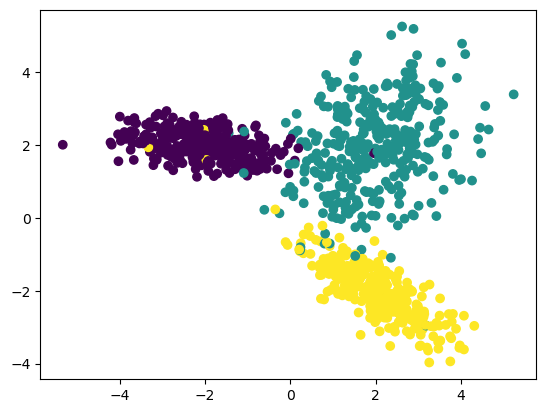

In [9]:
# Get datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])

MNIST data shape:  (1000, 784) (1000,)


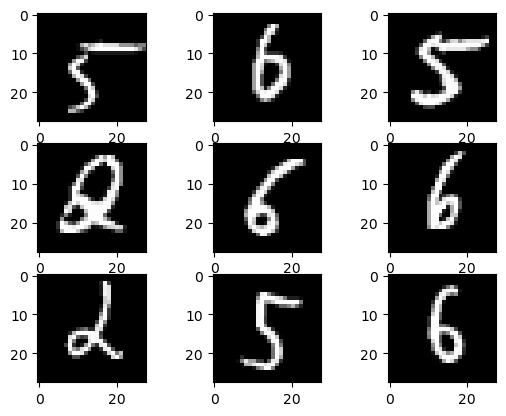

In [10]:
mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)

for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

In [6]:
syn_data["trainX"]

array([[6.45836059, 6.33615717],
       [7.0969569 , 0.93636804],
       [6.79162577, 6.89981478],
       ...,
       [5.51968087, 2.95278262],
       [3.77140398, 5.71856747],
       [5.16551569, 4.85537577]])

In [11]:
classifier_syn = MyClassifier(K=len(set(syn_data["trainY"])))
classifier_mnist = MyClassifier(K=len(set(mnist_data["trainY"])))

classifier_syn.train(syn_data)
classifier_mnist.train(mnist_data)

result1 = {
    'synthetic_test_accuracy':classifier_syn.evaluate(syn_data["testX"], syn_data["testY"]), 
    'mnist_test_accuracy':classifier_mnist.evaluate(mnist_data["testX"], mnist_data["testY"])
}

In [12]:
result1

{'synthetic_test_accuracy': 0.71, 'mnist_test_accuracy': 0.87}

In [13]:
result2 = {
    'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[], 'classification_accuracy':[]},
    'mnist':{'K':[3, 10, 32], 'clustering_nmi':[], 'classification_accuracy':[]}
}

In [14]:
for K in result2["synthetic"]["K"]:
    cluster_syn = MyClustering(K)
    cluster_syn.train(syn_data["trainX"], maxiter=30)
    cluster_syn.align_labels(syn_data["trainY"])
    result2["synthetic"]['clustering_nmi'].append(cluster_syn.evaluate_clustering(syn_data["trainY"]))
    cluster_syn.align_labels(syn_data["trainY"])
    result2["synthetic"]['classification_accuracy'].append(
       cluster_syn.evaluate_classification(syn_data["testX"], syn_data["testY"])
    )

train acc is:  0.856
train acc is:  0.845
train acc is:  0.886


In [15]:
# strongly recommend to first perform PCA to reduce the dimension
# sparse-NMF takes **very long** to solve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

std = StandardScaler()
pca = PCA(n_components=70)
trainX_std = std.fit_transform(mnist_data["trainX"])
testX_std = std.transform(mnist_data["testX"])
trainX_pca = pca.fit_transform(trainX_std)
testX_pca = pca.transform(testX_std)

# to feed into sparseNMF, we need to make our datapoints none-negative
nn = MinMaxScaler()
trainX_nn = nn.fit_transform(trainX_pca)
testX_nn = nn.transform(testX_pca)

In [16]:
for K in result2["mnist"]["K"]:
    cluster_mnist = MyClustering(K)
    cluster_mnist.train(trainX_nn)
    cluster_mnist.align_labels(mnist_data["trainY"])
    result2["mnist"]['clustering_nmi'].append(cluster_mnist.evaluate_clustering(mnist_data["trainY"]))
    result2["mnist"]['classification_accuracy'].append(
        cluster_mnist.evaluate_classification(testX_nn, mnist_data["testY"])
    )

train acc is:  0.558
train acc is:  0.868
train acc is:  0.953


In [17]:
result2

{'synthetic': {'K': [3, 5, 10],
  'clustering_nmi': [0.642100870904127,
   0.6213227930277947,
   0.6929457683706974],
  'classification_accuracy': [0.866, 0.88, 0.814]},
 'mnist': {'K': [3, 10, 32],
  'clustering_nmi': [0.2479523240233077, 0.62842199487691, 0.8024136859649125],
  'classification_accuracy': [0.528, 0.838, 0.912]}}

In [28]:
result3 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[], 'test_accuracy(random)':[]},
            'mnist': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[], 'test_accuracy(random)':[]}}

In [29]:
for p in result3["synthetic"]["label_percentage"]:
    classifier = MyClassifier(K=len(set(syn_data["trainY"])))
    selecter = MyLabelSelection(ratio=p)

    sel = selecter.select(syn_data["trainX"])
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(our algo)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))
    
    n, _ = syn_data["trainX"].shape
    sel = np.random.randint(0, n, size=int(n*p))
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(random)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))

In [30]:
for p in result3["mnist"]["label_percentage"]:
    classifier = MyClassifier(K=len(set(syn_data["trainY"])))
    selecter = MyLabelSelection(ratio=p)

    sel = selecter.select(mnist_data["trainX"])
    sel_data = {"trainX": mnist_data["trainX"][sel, :], "trainY": mnist_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["mnist"]["test_accuracy(our algo)"].append(classifier.evaluate(mnist_data["testX"], mnist_data["testY"]))
    
    n, _ = mnist_data["trainX"].shape
    sel = np.random.randint(0, n, size=int(n*p))
    sel_data = {"trainX": mnist_data["trainX"][sel, :], "trainY": mnist_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["mnist"]["test_accuracy(random)"].append(classifier.evaluate(mnist_data["testX"], mnist_data["testY"]))

In [31]:
result3

{'synthetic': {'label_percentage': [0.05, 0.1, 0.2, 0.5, 1],
  'test_accuracy(our algo)': [0.68, 0.694, 0.678, 0.334, 0.71],
  'test_accuracy(random)': [0.728, 0.744, 0.75, 0.678, 0.678]},
 'mnist': {'label_percentage': [0.05, 0.1, 0.2, 0.5, 1],
  'test_accuracy(our algo)': [0.568, 0.606, 0.728, 0.76, 0.87],
  'test_accuracy(random)': [0.606, 0.73, 0.762, 0.812, 0.842]}}

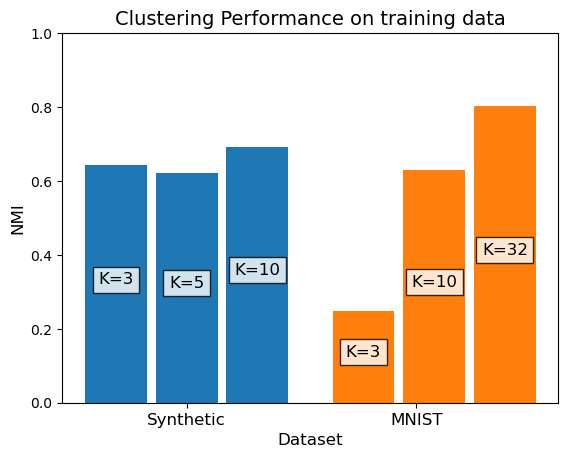

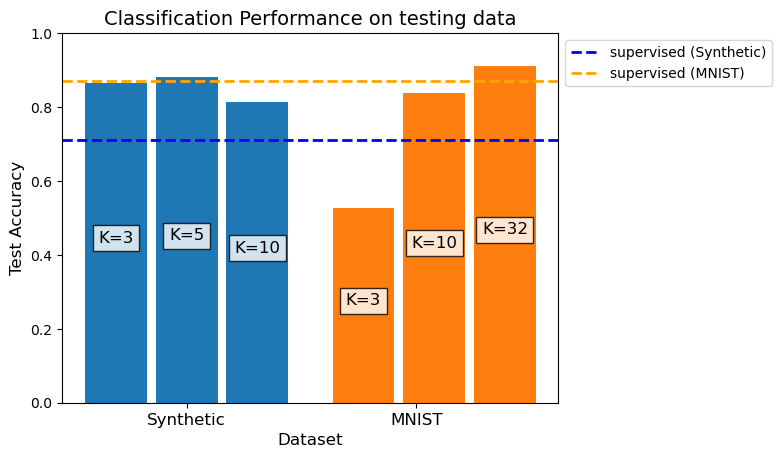

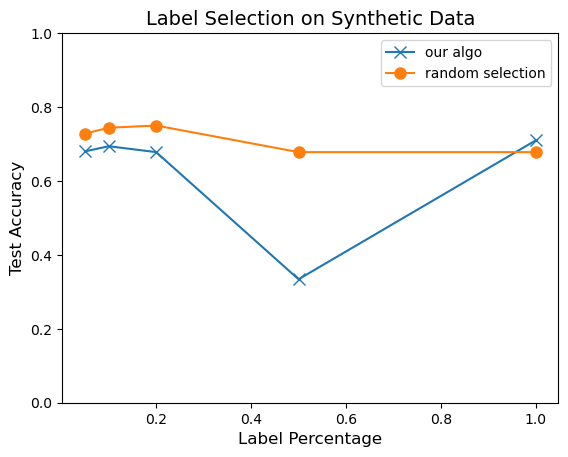

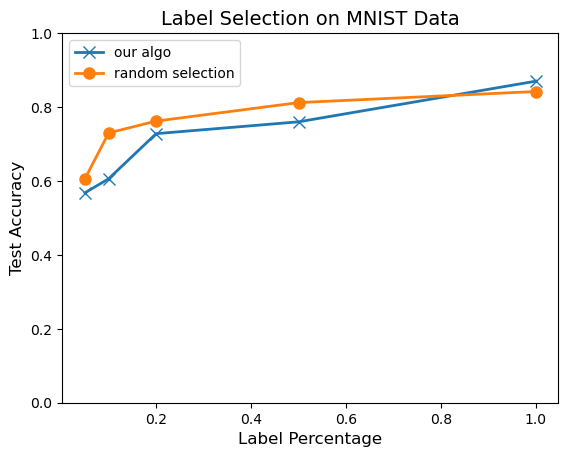

In [32]:
plot_result(result1, result2, result3)

In [51]:
clustering_percentage = {
    "mnist": {
        "percentage": [.05, .2, .4, .6, .8, 1],
        "cluster_acc": [],
        "cluster_nmi": []
    }, 
    "synthetic": {
        "percentage": [.05, .2, .4, .6, .8, 1],
        "cluster_acc": [],
        "cluster_nmi": []
    }
}

In [52]:
for p in clustering_percentage["synthetic"]["percentage"]:
    n, _ = syn_data["trainX"].shape
    rand_id = np.random.randint(0, n, size=int(n*p))
    trainX = syn_data["trainX"][rand_id, :]
    trainY = syn_data["trainY"][rand_id]
    cluster_syn = MyClustering(5)
    cluster_syn.train(trainX, maxiter=30)
    cluster_syn.align_labels(trainY)
    clustering_percentage["synthetic"]['cluster_nmi'].append(cluster_syn.evaluate_clustering(trainY))
    clustering_percentage["synthetic"]['cluster_acc'].append(
       cluster_syn.evaluate_classification(syn_data["testX"], syn_data["testY"])
    )

train acc is:  0.84
train acc is:  0.915
train acc is:  0.89
train acc is:  0.8916666666666667
train acc is:  0.88125
train acc is:  0.863


In [53]:
for p in clustering_percentage["mnist"]["percentage"]:
    n, _ = trainX_nn.shape
    rand_id = np.random.randint(0, n, size=int(n*p))
    trainX = trainX_nn[rand_id, :]
    trainY = mnist_data["trainY"][rand_id]
    cluster_syn = MyClustering(5)
    cluster_syn.train(trainX, maxiter=30)
    cluster_syn.align_labels(trainY)
    clustering_percentage["mnist"]['cluster_nmi'].append(cluster_syn.evaluate_clustering(trainY))
    clustering_percentage["mnist"]['cluster_acc'].append(
       cluster_syn.evaluate_classification(testX_nn, mnist_data["testY"])
    )

train acc is:  0.8
train acc is:  0.775
train acc is:  0.55
train acc is:  0.6583333333333333
train acc is:  0.63125
train acc is:  0.742


In [54]:
clustering_percentage

{'mnist': {'percentage': [0.05, 0.2, 0.4, 0.6, 0.8, 1],
  'cluster_acc': [0.676, 0.74, 0.518, 0.602, 0.59, 0.808],
  'cluster_nmi': [0.5254446766131607,
   0.4175982907614064,
   0.23315910854553076,
   0.31738004202058473,
   0.3354395179796256,
   0.44745076778024245]},
 'synthetic': {'percentage': [0.05, 0.2, 0.4, 0.6, 0.8, 1],
  'cluster_acc': [0.882, 0.888, 0.918, 0.876, 0.89, 0.836],
  'cluster_nmi': [0.6358413465369077,
   0.7716996973721222,
   0.6984408518136794,
   0.7088847498495814,
   0.6860300510207092,
   0.6532926077583405]}}

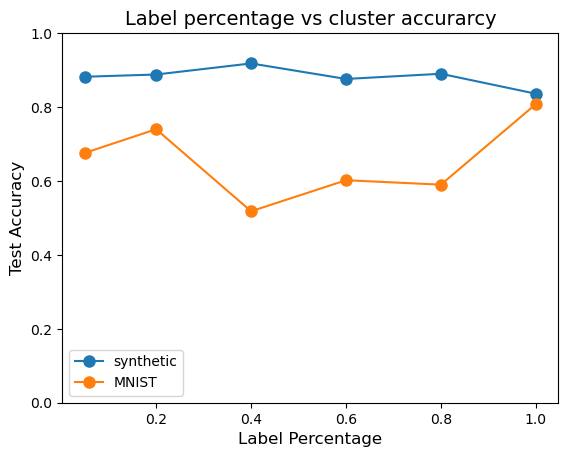

In [56]:
from matplotlib import pyplot as plt

plt.plot(clustering_percentage["synthetic"]['percentage'], clustering_percentage['synthetic']['cluster_acc'], label='synthetic', marker='o', markersize=8)
plt.plot(clustering_percentage["mnist"]['percentage'], clustering_percentage['mnist']['cluster_acc'], label='MNIST', marker='o', markersize=8)
plt.ylim(0,1)
plt.legend()
plt.xlabel("Label Percentage", fontsize=12) 
plt.ylabel('Test Accuracy', fontsize=12)
plt.title("Label percentage vs cluster accurarcy", fontsize=14)
plt.savefig("percentage.png", dpi=300)